In [1]:
# Installation Missingno (missing values library), TensorFlow and Spacy
!pip install missingno -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!pip install tensorflow -q
!pip install plotly -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Import des librairies TensorFlow & Pathlib 
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import seaborn as sns
import spacy
import missingno as msno
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from plotly import graph_objects as go
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU 
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import BinaryAccuracy
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from plotly import express as px
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D
from IPython.display import Image
from IPython import display
import matplotlib.cm as cm
import glob 
import os 
import time 
from spacy.lang.en.stop_words import STOP_WORDS
import warnings
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")
tf.__version__

'2.6.0'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(train.size)
train.head()

(7613, 5)
38065


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(test.shape)
print(test.size)
print(train['target'].unique())

test.head()

(3263, 4)
13052
[1 0]


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# First, we'll work on the train dataset to visualize tweets, and then clean them

count_vectorizer = feature_extraction.text.CountVectorizer()

# let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train["text"][0:5])
example_train_vectors

<5x54 sparse matrix of type '<class 'numpy.int64'>'
	with 61 stored elements in Compressed Sparse Row format>

In [6]:
# we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [7]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
train['drama'] = train['target'].apply(lambda x: "Disaster" if x == 1 else "No disaster") 

42.97 % of those tweets concern a disaster in our data


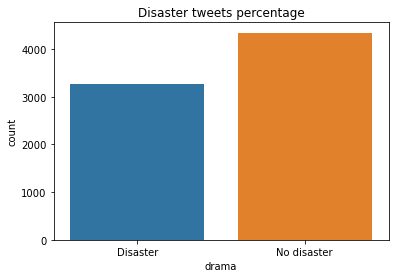

In [9]:
# We want to make a vizualisation of the dataset and seeing how the tweets 
# are splited 

ax = sns.countplot(train['drama'])
ax.set_title('Disaster tweets percentage')

print(f'{train.target[train.target==1].count()/train.target.count()*100:.2f} % of those tweets concern a disaster in our data')

In [10]:
train['text'][7554]

'James Kunstler: How bad architecture wrecked cities http://t.co/Ac6I3tE8mT #residualincome #mlm http://t.co/Wq0JLsHW1g'

In [11]:
train['text'][7610]

'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'

In [12]:
train['text'][67]

"'I can't have kids cuz I got in a bicycle accident &amp; split my testicles. it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER"

In [13]:
# Let's to clean our column text, removing urls, punctuations and other
# characters that we won't need

import re
train['clean_text'] = train['text'].str.replace("[#]", "")
train['clean_text'] = train['clean_text'].apply(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x, flags=re.MULTILINE))
train['clean_text'] = train['clean_text'].apply(lambda x:''.join(i for i in x if i.isalnum() or i in [" ","'"]).lower())

In [14]:
train['clean_text'][7554]

'james kunstler how bad architecture wrecked cities  residualincome mlm '

In [15]:
train['clean_text'][12]

"raining flooding florida tampabay tampa 18 or 19 days i've lost count "

In [16]:
train['clean_text'][7610]

'm194 0104 utc5km s of volcano hawaii '

In [17]:
# We can lemmatize the new (clean) text column, just in case if some words 
# are badly written or if they contain wrong orthography 

import en_core_web_sm
nlp = en_core_web_sm.load()
a = nlp(train['clean_text'][12])

In [18]:
corr = [element.lemma_ for element in a]
corr

['rain',
 'flood',
 'florida',
 'tampabay',
 'tampa',
 '18',
 'or',
 '19',
 'day',
 'I',
 "'ve",
 'lose',
 'count']

In [19]:
# Lemmatization
train['clean_text'] = train['clean_text'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [20]:
train.head()

,id,keyword,location,text,target,drama,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Disaster,our deed be the reason of this earthquake may ...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Disaster,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Disaster,all resident ask to ' shelter in place ' be be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Disaster,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Disaster,just got send this photo from ruby alaska as s...


In [21]:
# Tokenization
tokenizer_train = tf.keras.preprocessing.text.Tokenizer()
tokenizer_train.fit_on_texts(train['clean_text'])

In [22]:
tokenizer_train.word_index

{'be': 1,
 'the': 2,
 'a': 3,
 'i': 4,
 'in': 5,
 'to': 6,
 'of': 7,
 'and': 8,
 "'": 9,
 'for': 10,
 'you': 11,
 'on': 12,
 'have': 13,
 'it': 14,
 'my': 15,
 'that': 16,
 'do': 17,
 'with': 18,
 'at': 19,
 'by': 20,
 'this': 21,
 "n't": 22,
 'we': 23,
 'from': 24,
 "'s": 25,
 'like': 26,
 'get': 27,
 'fire': 28,
 'they': 29,
 'as': 30,
 'up': 31,
 'just': 32,
 'so': 33,
 'but': 34,
 'he': 35,
 'not': 36,
 'amp': 37,
 'your': 38,
 'go': 39,
 'out': 40,
 'all': 41,
 'after': 42,
 'will': 43,
 'no': 44,
 'an': 45,
 'when': 46,
 'if': 47,
 'new': 48,
 'what': 49,
 'via': 50,
 'now': 51,
 'more': 52,
 'about': 53,
 'one': 54,
 'or': 55,
 'people': 56,
 'say': 57,
 'there': 58,
 'how': 59,
 'over': 60,
 'who': 61,
 'news': 62,
 'see': 63,
 'burn': 64,
 'into': 65,
 'video': 66,
 'kill': 67,
 'can': 68,
 'make': 69,
 '2': 70,
 'crash': 71,
 'come': 72,
 'bomb': 73,
 'emergency': 74,
 'time': 75,
 'disaster': 76,
 'attack': 77,
 'body': 78,
 'year': 79,
 'look': 80,
 'would': 81,
 'police': 

In [23]:
# Create an instance of our tokenization
train['text_instance'] = tokenizer_train.texts_to_sequences(train['clean_text'])
train.head()

,id,keyword,location,text,target,drama,clean_text,text_instance
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Disaster,our deed be the reason of this earthquake may ...,"[125, 3877, 1, 2, 557, 7, 21, 281, 143, 1574, ..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Disaster,forest fire near la ronge sask canada,"[216, 28, 264, 662, 5730, 5731, 1130]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Disaster,all resident ask to ' shelter in place ' be be...,"[41, 1575, 593, 6, 9, 1904, 5, 461, 9, 1, 1, 5..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Disaster,13000 people receive wildfire evacuation order...,"[2517, 56, 2518, 152, 299, 412, 5, 100]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Disaster,just got send this photo from ruby alaska as s...,"[32, 400, 292, 21, 221, 24, 5733, 1715, 30, 28..."


In [24]:
# Create token sequences of same lenght
padded_text = tf.keras.preprocessing.sequence.pad_sequences(train["text_instance"], padding="post")
padded_text

array([[ 125, 3877,    1, ...,    0,    0,    0],
       [ 216,   28,  264, ...,    0,    0,    0],
       [  41, 1575,  593, ...,    0,    0,    0],
       ...,
       [2897, 3871, 5698, ...,    0,    0,    0],
       [  82,  902,   42, ...,    0,    0,    0],
       [   2,  193,   52, ...,    0,    0,    0]], dtype=int32)

In [25]:
# Creation of tf.data.Dataset for our text tensor
text_ds = tf.data.Dataset.from_tensor_slices((padded_text, train["target"].values))
text_ds

<TensorSliceDataset shapes: ((33,), ()), types: (tf.int32, tf.int64)>

In [26]:
# Train Test Split
TAKE_SIZE = 5000

train_data = text_ds.skip(TAKE_SIZE).shuffle(1000)
train_data = train_data.batch(64)

test_data = text_ds.take(TAKE_SIZE)
test_data = test_data.batch(64)

### Tweet words modelling 

In [27]:
vocab_size = len(tokenizer_train.word_index)

model = tf.keras.Sequential([
                  # Layer Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 64, input_shape=[23,]),
                  tf.keras.layers.BatchNormalization(),
                  # Layer Dense classique 
                  tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                  tf.keras.layers.Dense(32, activation='relu'),

                  # Output layer with number of output neurons equal to class number with softmax function
                  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 64)            1024320   
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
dense (Dense)                (None, 23, 64)            4160      
_________________________________________________________________
dense_1 (Dense)              (None, 23, 32)            2080      
_________________________________________________________________
dense_2 (Dense)              (None, 23, 1)             33        
Total params: 1,030,849
Trainable params: 1,030,721
Non-trainable params: 128
_________________________________________________________________


In [28]:
# Using a simple compiler with an Adam optimizer to calculate our gradients 
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [29]:
# Model training
history = model.fit(train_data, epochs=25, validation_data=test_data)

Epoch 1/25
41/41 [==============================] - 2s 27ms/step - loss: 1.1618 - binary_accuracy: 0.5801 - val_loss: 1.0554 - val_binary_accuracy: 0.4789
Epoch 2/25
41/41 [==============================] - 1s 19ms/step - loss: 0.9156 - binary_accuracy: 0.6264 - val_loss: 0.8927 - val_binary_accuracy: 0.5911
Epoch 3/25
41/41 [==============================] - 1s 21ms/step - loss: 0.7740 - binary_accuracy: 0.6327 - val_loss: 0.7987 - val_binary_accuracy: 0.5949
Epoch 4/25
41/41 [==============================] - 1s 19ms/step - loss: 0.6943 - binary_accuracy: 0.6340 - val_loss: 0.7462 - val_binary_accuracy: 0.5885
Epoch 5/25
41/41 [==============================] - 1s 22ms/step - loss: 0.6514 - binary_accuracy: 0.6330 - val_loss: 0.7158 - val_binary_accuracy: 0.5945
Epoch 6/25
41/41 [==============================] - 1s 19ms/step - loss: 0.6265 - binary_accuracy: 0.6347 - val_loss: 0.7019 - val_binary_accuracy: 0.5913
Epoch 7/25
41/41 [==============================] - 1s 21ms/step - los

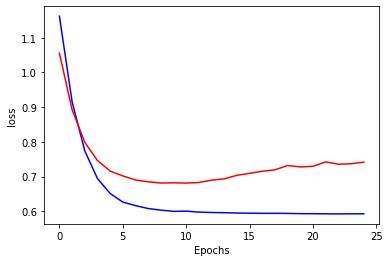

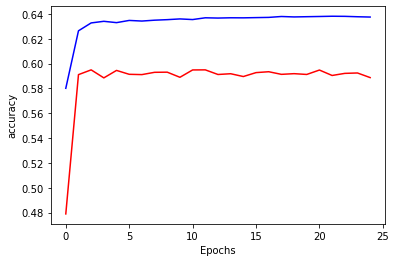

In [30]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# Visualisation de l'entrainement sur l'accuracy 
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [31]:
#int_sequences_input = keras.Input(shape=(None,), dtype="int64")
#embedded_sequences = embedding_layer(int_sequences_input)
model1 = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size+1, 64, input_shape=[23,]),
            #tf.keras.layers.Conv1D(64, 5, activation="relu",padding='same'),
            tf.keras.layers.MaxPooling1D(3),
            tf.keras.layers.Conv1D(32, 5, activation="relu",padding='same'),
            tf.keras.layers.MaxPooling1D(pool_size=3),
            tf.keras.layers.Conv1D(16, 5, activation="relu",padding='same'),
            #tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(16, activation="relu",kernel_regularizer=regularizers.l1_l2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model1.summary()

# Using a simple compiler with an Adam optimizer to calculate our gradients 
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Model training
history1 = model1.fit(train_data, epochs=20, validation_data=test_data)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 64)            1024320   
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7, 32)             10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 16)             2576      
_________________________________________________________________
dense_3 (Dense)              (None, 2, 16)             272       
_________________________________________________________________
dropout (Dropout)            (None, 2, 16)            

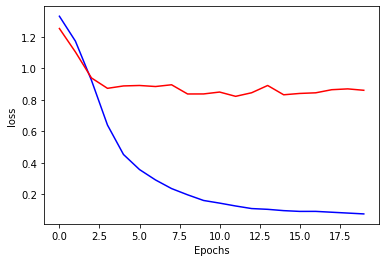

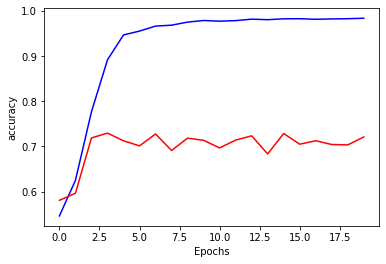

In [32]:
# Visualization of the training process on the loss function 
plt.plot(history1.history["loss"], color="b")
plt.plot(history1.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# Visualisation de l'entrainement sur l'accuracy 
plt.plot(history1.history["binary_accuracy"], color="b")
plt.plot(history1.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [33]:
embedding_dim = 256    
max_length = 23        
#training_size=50000


model2 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 100, input_shape=[23,]),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=124, return_sequences=True),
        tf.keras.layers.LSTM(units=62,return_sequences=True),
        tf.keras.layers.LSTM(64,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model2.summary()

# Using a simple compiler with an Adam optimizer to calculate our gradients 
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Model training
history2 = model2.fit(train_data, epochs=50, validation_data=test_data)

#Nous avons opté pour l’utilisation de différents types de réseaux profonds : notre première approche
#fut de maximiser individuellement le score de chacun de ces réseaux et de mieux comprendre les
#données de test à partir de leurs sorties.
#CNN : Il s’agit d’un CNN d’une couche de convolution de 64 neurones et une fenêtre de taille 5. On
#applique ensuite un max pooling global avant d’insérer une couche de 128 neurones, un dropout de
#0.1 et la couche de sortie.
#4. https://keras.io/
#c ATALA 2018 304
#CNN 2 : Le modèle est composé de deux couches de convolutions de 64 filtres et d’une taille de
#fenêtre de 5. Un max pooling est appliqué après chaque convolution. On insert un dropout de 0.3
#après la première couche de convolution. Enfin, on ajoute une couche dense de 64 neurones suivie par
#une couche de sortie de taille correspondante au nombre de classes.
#CNN 3 : On définit 3 sous modèles avec les paramètres suivants : une couche de convolution de 64
#neurones et des fenêtres de tailles 3, 4 puis 5. On y ajoute un max pooling global. Ces 3 modèles sont
#fusionnés grâce à la couche Merge de Keras. On ajoute par la suite un dropout de 0.5 suivi d’une
#couche dense de 64 neurones et de la couche de sortie.
#BLSTM : La taille du LSTM est de 64 neurones (128 pour le BLSTM). On y ajoute un dropout de
#0.5 suivi de la couche de sortie.
#GRU : Une couche GRU de 64 neurones suivie de la couche de sortie.
#LSTM : Une couche LSTM de 64 neurones suivie de la couche de sortie

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 100)           1600500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 23, 124)           111600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 62)            46376     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                32512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,791,053
Trainable params: 1,791,053
Non-trainable params: 0
____________________________________________

InvalidArgumentError:  Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-33-357cbd519852>:23) ]] [Op:__inference_train_function_21536]

Function call stack:
train_function


In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history2.history["loss"], color="b")
plt.plot(history2.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# Visualisation de l'entrainement sur l'accuracy 
plt.plot(history2.history["binary_accuracy"], color="b")
plt.plot(history2.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
embedding_matrix=np.zeros((vocab_size+1,100))

In [ ]:
embedding_matrix